**Program**: 8_NSCH_XGB_Analysis<br>
**Class**: Fall 2025, Machine Learning, Project<br>
**Member**: Vanessa Thorsten<br>
**Description**: This program reads in the analysis dataset NSCH_fam.csv, which provides data at the child-level and requires weighting the data due to the sampling and response. Variables are kept and XGBoost analysis is performed.<br>
<br>
**Outputs**: The following data visualizations are provided for the dataset:<br>

**Program History/Modifications**:<br>
11/16/2025    Initial Version

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, recall_score, classification_report
from sklearn.metrics import make_scorer #use for weighted roc auc
from sklearn.tree import plot_tree

from sklearn.inspection import permutation_importance

from sklearn.inspection import PartialDependenceDisplay

In [2]:
# American Health Ratings State Level Data
# We are interested in prediction. Add state-level features to the individual-level file
NSCH_AHR_state = pd.read_csv("NSCH_AHR_state.csv")

# Include only variables from AHR to prevent leakage from rolled-up state-level values for 
# NSCH. Do not include variables that are also collected for the child (such as 
# insurance and immunization. Also did not include percent complete hs.
AHR_state = NSCH_AHR_state[["STATE", "population_LT18", "Poverty", 
                            "primary_care_providers", "public_health", 
                            "support_engagement_annual", "Region"]].copy()


AHR_state.head()

,STATE,population_LT18,Poverty,primary_care_providers,public_health,support_engagement_annual,Region
0,AK,23.9,10.4,359.3,334.0,0.024,West
1,AL,22.1,16.0,241.0,137.0,-0.745,South
2,AR,23.0,16.3,241.4,128.0,-1.020,South
3,AZ,21.3,12.6,258.2,84.0,0.125,West
4,CA,21.7,12.0,229.7,173.0,0.199,West


In [3]:
AHR_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   STATE                      51 non-null     object 
 1   population_LT18            51 non-null     float64
 2   Poverty                    51 non-null     float64
 3   primary_care_providers     51 non-null     float64
 4   public_health              51 non-null     float64
 5   support_engagement_annual  50 non-null     float64
 6   Region                     51 non-null     object 
dtypes: float64(5), object(2)
memory usage: 2.9+ KB


In [4]:
#Child level data
df_fam = pd.read_csv("NSCH_fam.csv")

df_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54159 entries, 0 to 54158
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              54159 non-null  int64  
 1   FIPSST                  54159 non-null  int64  
 2   STATE                   54159 non-null  object 
 3   STATE_NAME              54159 non-null  object 
 4   STRATUM                 54159 non-null  int64  
 5   HHID                    54159 non-null  int64  
 6   FORMTYPE                54159 non-null  int64  
 7   TOTKIDS_R               54159 non-null  int64  
 8   FWC                     54159 non-null  float64
 9   SC_AGE_YEARS            54159 non-null  int64  
 10  SC_SEX                  54159 non-null  int64  
 11  age3_23                 54159 non-null  int64  
 12  age5_23                 54159 non-null  int64  
 13  sex_23                  54159 non-null  int64  
 14  hispanic_23             54159 non-null

In [5]:
# Keep only the variables needed for the analysis
df_fam = df_fam[["STATE", "FWC", "K2Q01", "SC_AGE_YEARS", 
                 "SC_SEX", "TOTKIDS_R", "HousingInstab_23", 
                 "WIC_23", "FoodCash_23", "povlev4_23", "FamCount_23",
                 "K4Q01", "smAdeqIns_23",
                 "ScreenTime_23", "HrsSleep_23", "PrevMed_23",
                 "AdultEduc_23"]].copy()
                 

# povlev4_23 is a four level variable
# if 0 < FPL_I1 = < 99 then povlev4_23 = 1;
# if 100 = < FPL_I1 = < 199 then povlev4_23 = 2;
# if 200 = < FPL_I1 = < 399 then povlev4_23 = 3;
# if 400 = < FPL_I1 then povlev4_23 = 4;
# label povlev4_23 = "Income level based on family poverty level status, imputed";

# FamCount_23- How many of the people living or staying in the child's 
# household are family members? 1 or 2 people; 3 people; 4 people; 5 people; 
# 6 or more people

# FoodCash_23 is 1= someone in house received food/cash assistance during the past 12 months from 3-5 sources
#                2= someone in house received food/cash assistance during the past 12 months from 1-2 sources
#                3= did not receive food/cash assistance during the past 12 months

df_fam.head()

,STATE,FWC,K2Q01,SC_AGE_YEARS,SC_SEX,TOTKIDS_R,HousingInstab_23,WIC_23,FoodCash_23,povlev4_23,FamCount_23,K4Q01,smAdeqIns_23,ScreenTime_23,HrsSleep_23,PrevMed_23,AdultEduc_23
0,CA,1318.476840,2.0,11,1,1,2.0,2.0,2.0,3,2.0,2.0,1.0,4.0,2.0,1.0,3
1,CA,978.499881,2.0,14,2,2,2.0,2.0,2.0,4,3.0,1.0,1.0,5.0,1.0,1.0,4
2,CA,904.191765,3.0,17,2,1,2.0,NaN,2.0,2,4.0,1.0,1.0,4.0,1.0,1.0,2
3,CA,1092.097256,1.0,12,2,2,2.0,2.0,2.0,2,3.0,1.0,1.0,4.0,1.0,2.0,3
4,CA,586.387870,1.0,10,2,2,2.0,2.0,3.0,2,3.0,2.0,2.0,5.0,1.0,2.0,2


In [6]:
df_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54159 entries, 0 to 54158
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STATE             54159 non-null  object 
 1   FWC               54159 non-null  float64
 2   K2Q01             54159 non-null  float64
 3   SC_AGE_YEARS      54159 non-null  int64  
 4   SC_SEX            54159 non-null  int64  
 5   TOTKIDS_R         54159 non-null  int64  
 6   HousingInstab_23  53140 non-null  float64
 7   WIC_23            52887 non-null  float64
 8   FoodCash_23       53137 non-null  float64
 9   povlev4_23        54159 non-null  int64  
 10  FamCount_23       52375 non-null  float64
 11  K4Q01             54159 non-null  float64
 12  smAdeqIns_23      54159 non-null  float64
 13  ScreenTime_23     53410 non-null  float64
 14  HrsSleep_23       53103 non-null  float64
 15  PrevMed_23        54159 non-null  float64
 16  AdultEduc_23      54159 non-null  int64 

In [7]:
#Add labeled variable for graphs
PrevMed_23_labels = {
    1: 'Preventative care',
    2: 'No preventative care'
}

PrevMed_23_order = ['Preventative care', 'No preventative care']

df_fam['PrevMed_23_labeled'] = df_fam['PrevMed_23'].map(PrevMed_23_labels)

df_fam["PrevMed_23_labeled"] = pd.Categorical(
    df_fam["PrevMed_23_labeled"],
    categories=PrevMed_23_order,
    ordered=True
)

#Add 0/1 variable for models. 2 -> 0 (Did not receive preventative care), 1 -> 1 (Received preventative care), NAN stays NAN
df_fam['noprecare'] = df_fam['PrevMed_23'].map({2: 1, 1: 0}).astype('Int64')

In [8]:
cols = ['PrevMed_23', 'noprecare', "K2Q01", "SC_AGE_YEARS", 
        "SC_SEX", "TOTKIDS_R", "HousingInstab_23", 
        "WIC_23", "FoodCash_23", "povlev4_23", "FamCount_23",
        "K4Q01", "smAdeqIns_23", "ScreenTime_23", "HrsSleep_23",
        "AdultEduc_23"]

for col in cols:
    print(f"{df_fam[col].value_counts()}\n")


PrevMed_23
1.0    45287
2.0     8872
Name: count, dtype: int64

noprecare
0    45287
1     8872
Name: count, dtype: Int64

K2Q01
1.0    35822
2.0    13879
3.0     3796
4.0      596
5.0       66
Name: count, dtype: int64

SC_AGE_YEARS
2     4605
5     4008
3     3950
4     3944
16    3453
17    3370
15    3099
1     2813
14    2741
13    2728
6     2629
11    2556
8     2515
12    2475
7     2469
9     2460
10    2423
0     1921
Name: count, dtype: int64

SC_SEX
1    27795
2    26364
Name: count, dtype: int64

TOTKIDS_R
2    22022
1    21021
3     7899
4     3217
Name: count, dtype: int64

HousingInstab_23
2.0    46482
1.0     6658
Name: count, dtype: int64

WIC_23
2.0    49114
1.0     3773
Name: count, dtype: int64

FoodCash_23
1.0    36491
2.0    13064
3.0     3582
Name: count, dtype: int64

povlev4_23
4    23004
3    16119
2     8464
1     6572
Name: count, dtype: int64

FamCount_23
3.0    20071
2.0    15690
4.0     8842
5.0     4661
1.0     3111
Name: count, dtype: int64

K4Q01
1.0 

In [9]:
# Using isna() to count NaNs in each column
column_nan_count_isna = df_fam.isna().sum()
print("NaN count per column using isna():") 
print(column_nan_count_isna)

NaN count per column using isna():
STATE                    0
FWC                      0
K2Q01                    0
SC_AGE_YEARS             0
SC_SEX                   0
TOTKIDS_R                0
HousingInstab_23      1019
WIC_23                1272
FoodCash_23           1022
povlev4_23               0
FamCount_23           1784
K4Q01                    0
smAdeqIns_23             0
ScreenTime_23          749
HrsSleep_23           1056
PrevMed_23               0
AdultEduc_23             0
PrevMed_23_labeled       0
noprecare                0
dtype: int64


In [10]:
# Fill missing values with the mode (most frequent value) for each column
for col in df_fam.columns:
    mode = df_fam[col].mode(dropna=True)
    if not mode.empty:
        df_fam[col] = df_fam[col].fillna(mode[0])
    else:
        print(f"Warning: No mode found for column '{col}' — possibly all NaNs.")


In [11]:
df_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54159 entries, 0 to 54158
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   STATE               54159 non-null  object  
 1   FWC                 54159 non-null  float64 
 2   K2Q01               54159 non-null  float64 
 3   SC_AGE_YEARS        54159 non-null  int64   
 4   SC_SEX              54159 non-null  int64   
 5   TOTKIDS_R           54159 non-null  int64   
 6   HousingInstab_23    54159 non-null  float64 
 7   WIC_23              54159 non-null  float64 
 8   FoodCash_23         54159 non-null  float64 
 9   povlev4_23          54159 non-null  int64   
 10  FamCount_23         54159 non-null  float64 
 11  K4Q01               54159 non-null  float64 
 12  smAdeqIns_23        54159 non-null  float64 
 13  ScreenTime_23       54159 non-null  float64 
 14  HrsSleep_23         54159 non-null  float64 
 15  PrevMed_23          54159 non-null  

In [12]:
#convert from float to int
cols_to_convert = ['K2Q01', 'HousingInstab_23', 'WIC_23',
                   'FoodCash_23', 'FamCount_23', 'smAdeqIns_23',
                   'K4Q01', 'ScreenTime_23',
                   'HrsSleep_23', 'PrevMed_23',"AdultEduc_23"]

df_fam[cols_to_convert] = df_fam[cols_to_convert].astype('int64')

In [13]:
column_nan_count_isna = df_fam.isna().sum()
print("NaN count per column using isna():") 
print(column_nan_count_isna)

NaN count per column using isna():
STATE                 0
FWC                   0
K2Q01                 0
SC_AGE_YEARS          0
SC_SEX                0
TOTKIDS_R             0
HousingInstab_23      0
WIC_23                0
FoodCash_23           0
povlev4_23            0
FamCount_23           0
K4Q01                 0
smAdeqIns_23          0
ScreenTime_23         0
HrsSleep_23           0
PrevMed_23            0
AdultEduc_23          0
PrevMed_23_labeled    0
noprecare             0
dtype: int64


In [14]:
#Merge the NSCH and AHR data
df_fam_xgb = pd.merge(df_fam, AHR_state, how = 'left',  on = 'STATE')

In [15]:
df_fam_xgb['Region'].value_counts()

Region
Midwest      15650
West         15436
South        15238
Northeast     7835
Name: count, dtype: int64

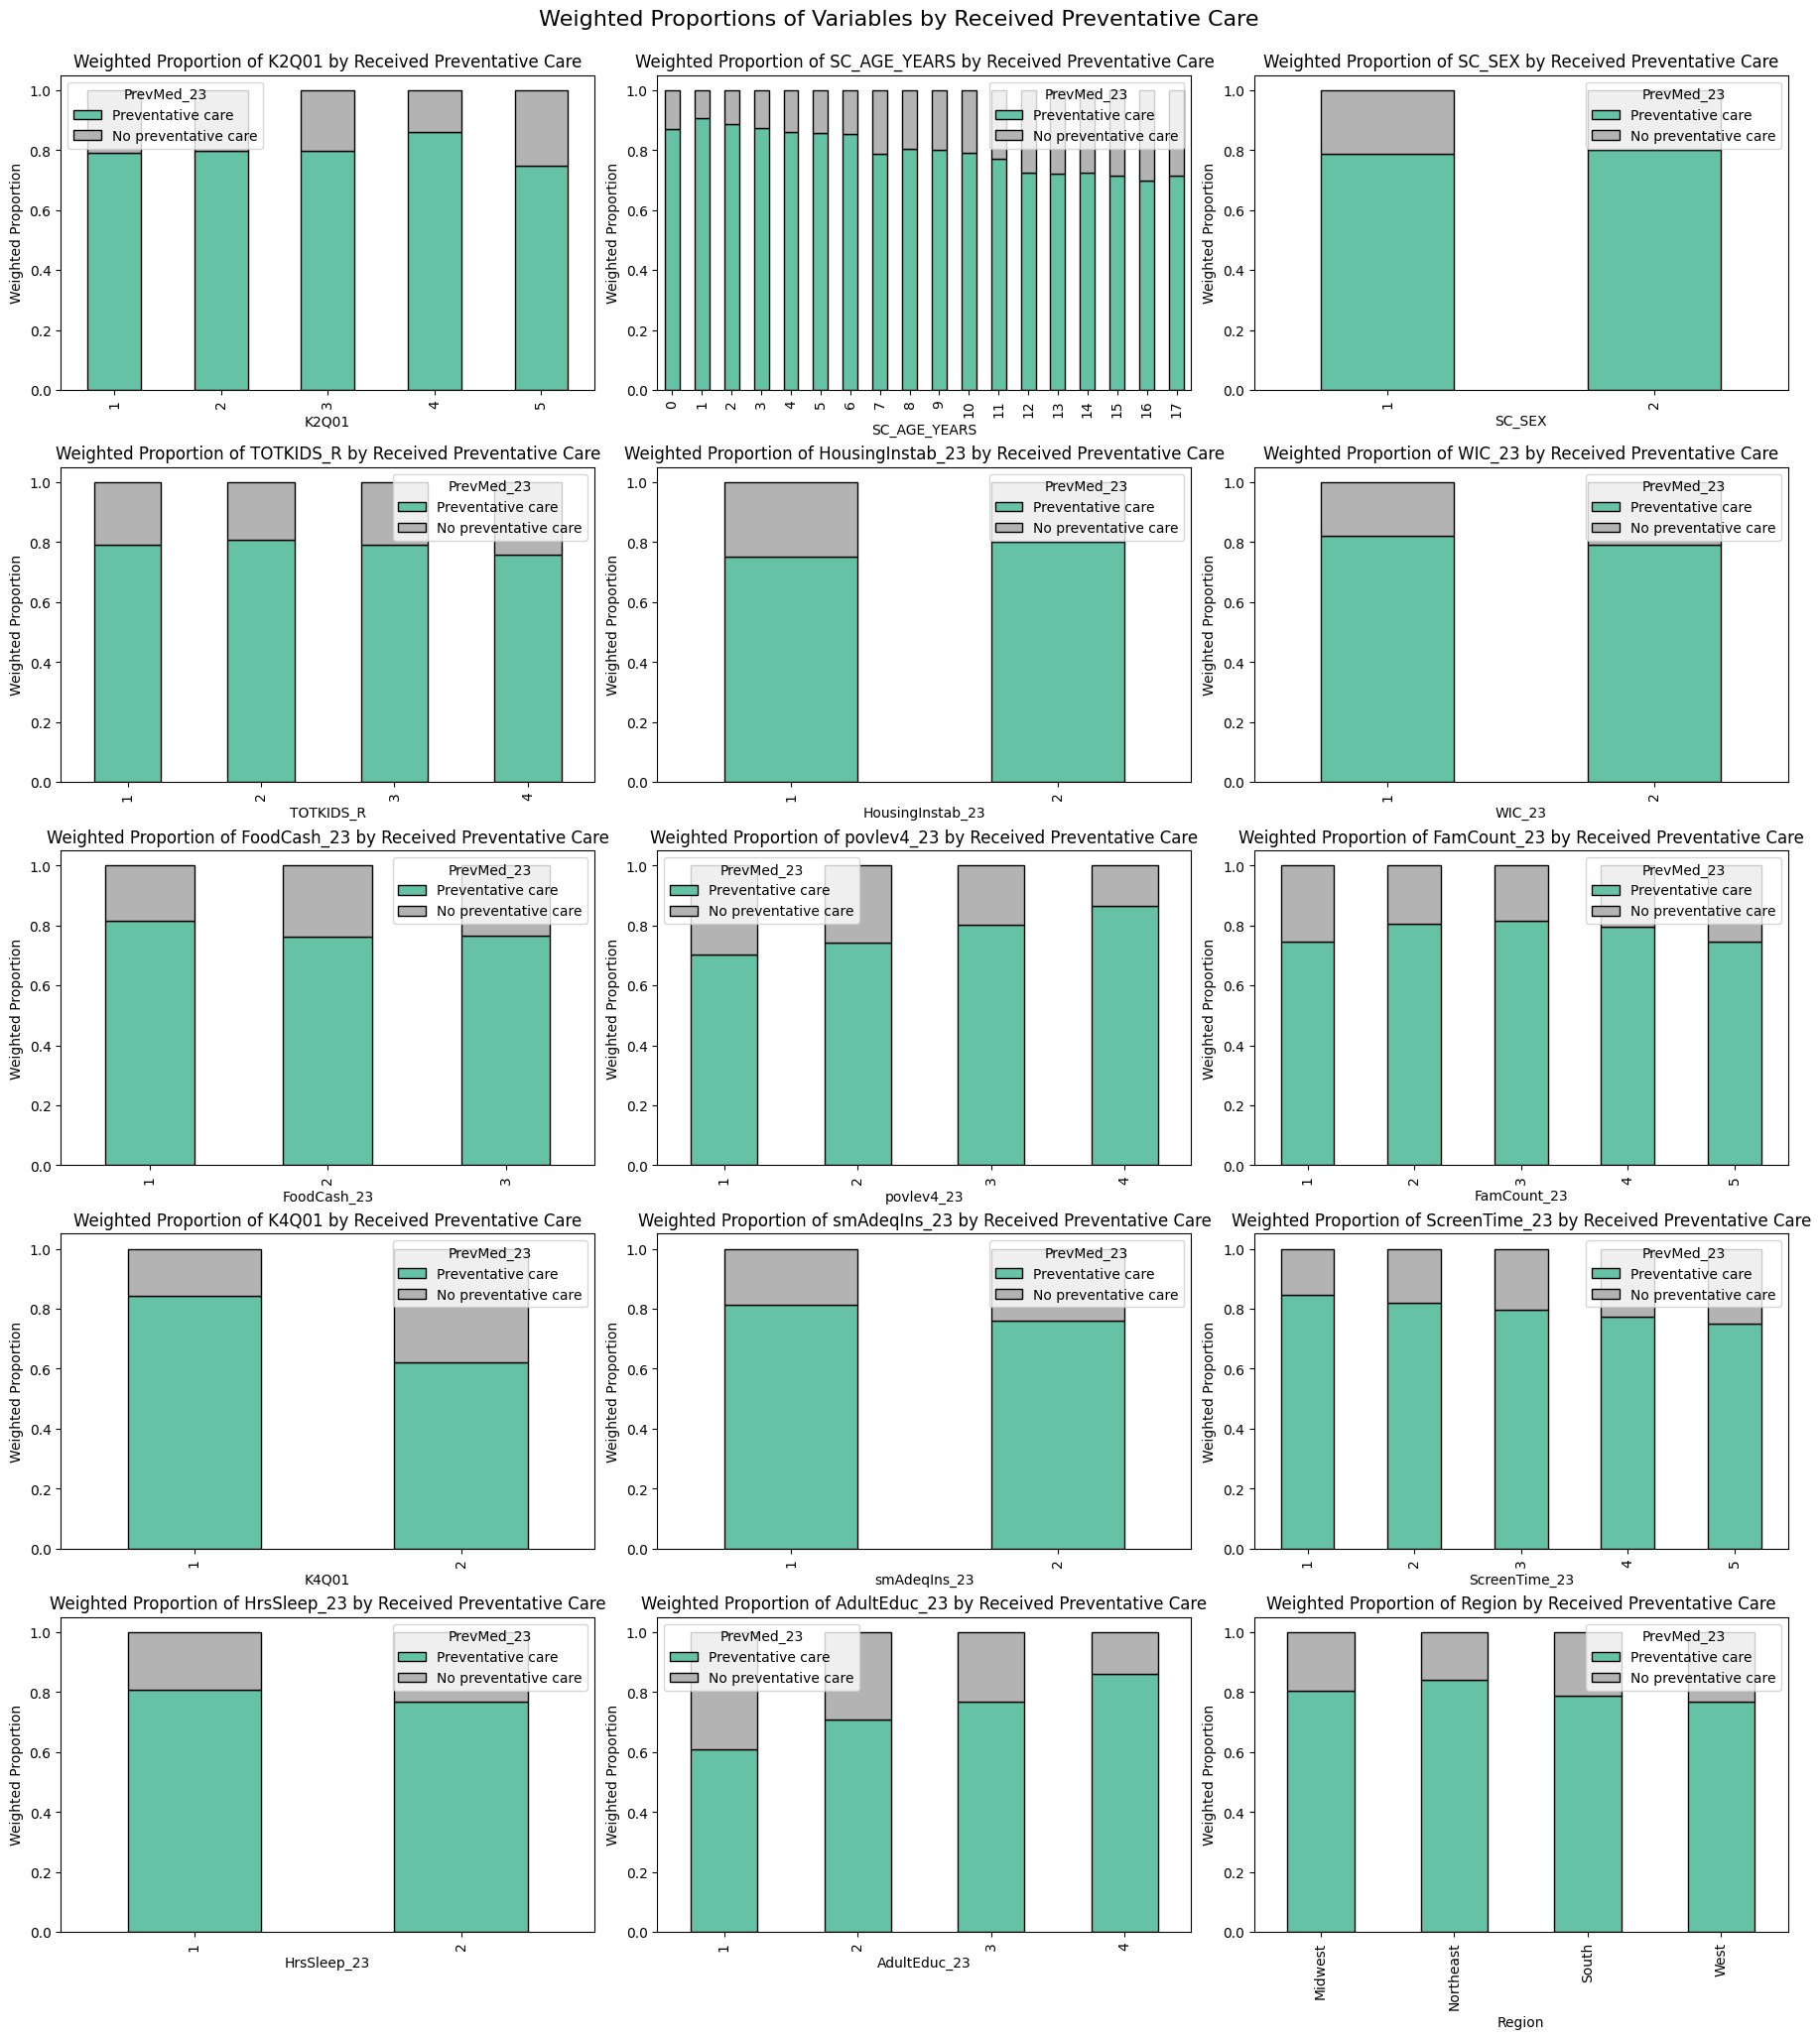

In [16]:
vars_to_plot = ["K2Q01", "SC_AGE_YEARS", 
                 "SC_SEX", "TOTKIDS_R", "HousingInstab_23", 
                 "WIC_23", "FoodCash_23", "povlev4_23", "FamCount_23",
                 "K4Q01", "smAdeqIns_23",
                 "ScreenTime_23", "HrsSleep_23", "AdultEduc_23", "Region"                
]

n_vars = len(vars_to_plot)
cols = 3
rows = math.ceil(n_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), constrained_layout=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    # Calculate weighted counts by variable and hue
    weighted_counts = (
        df_fam_xgb
        .groupby([var, 'PrevMed_23_labeled'], dropna=False, observed=False)['FWC']
        .sum()
        .reset_index()
        .rename(columns={'FWC': 'weighted_count'})
    )

    # Calculate total weighted counts per variable value
    total_counts = (
        weighted_counts
        .groupby(var)['weighted_count']
        .sum()
        .reset_index()
        .rename(columns={'weighted_count': 'total_weighted_count'})
    )

    # Merge totals back to weighted_counts to calculate proportions
    merged = weighted_counts.merge(total_counts, on=var)
    merged['prop'] = merged['weighted_count'] / merged['total_weighted_count']

    # Pivot for plotting stacked bars
    pivot_df = merged.pivot(index=var, columns='PrevMed_23_labeled', values='prop').fillna(0)

    # Sort index if possible (depends on your data type)
    pivot_df = pivot_df.sort_index()

    # Plot stacked bar
    pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='Set2', edgecolor='black')

    ax.set_title(f"Weighted Proportion of {var} by Received Preventative Care")
    ax.set_xlabel(var)
    ax.set_ylabel("Weighted Proportion")
    ax.legend(title='PrevMed_23')

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Weighted Proportions of Variables by Received Preventative Care', fontsize=16, y=1.02)
plt.show()

In [17]:
# -----------------------------------------------------
# 1. Weighted quantile function (must be defined first!)
# -----------------------------------------------------
def weighted_quantile(values, quantiles, sample_weight):
    """
    Compute weighted quantiles.
    values: array-like
    quantiles: array-like of quantiles in [0, 1]
    sample_weight: array-like of weights
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    sample_weight = np.array(sample_weight)

    # Remove any rows where value or weight is missing
    mask = (~np.isnan(values)) & (~np.isnan(sample_weight))
    values = values[mask]
    sample_weight = sample_weight[mask]

    if len(values) == 0:
        return [np.nan] * len(quantiles)

    # Sort by values
    sorter = np.argsort(values)
    values = values[sorter]
    sample_weight = sample_weight[sorter]

    # Compute cumulative weights as a percentage of total
    cum_weights = np.cumsum(sample_weight)
    total_weight = np.sum(sample_weight)

    return np.interp(quantiles, cum_weights / total_weight, values)

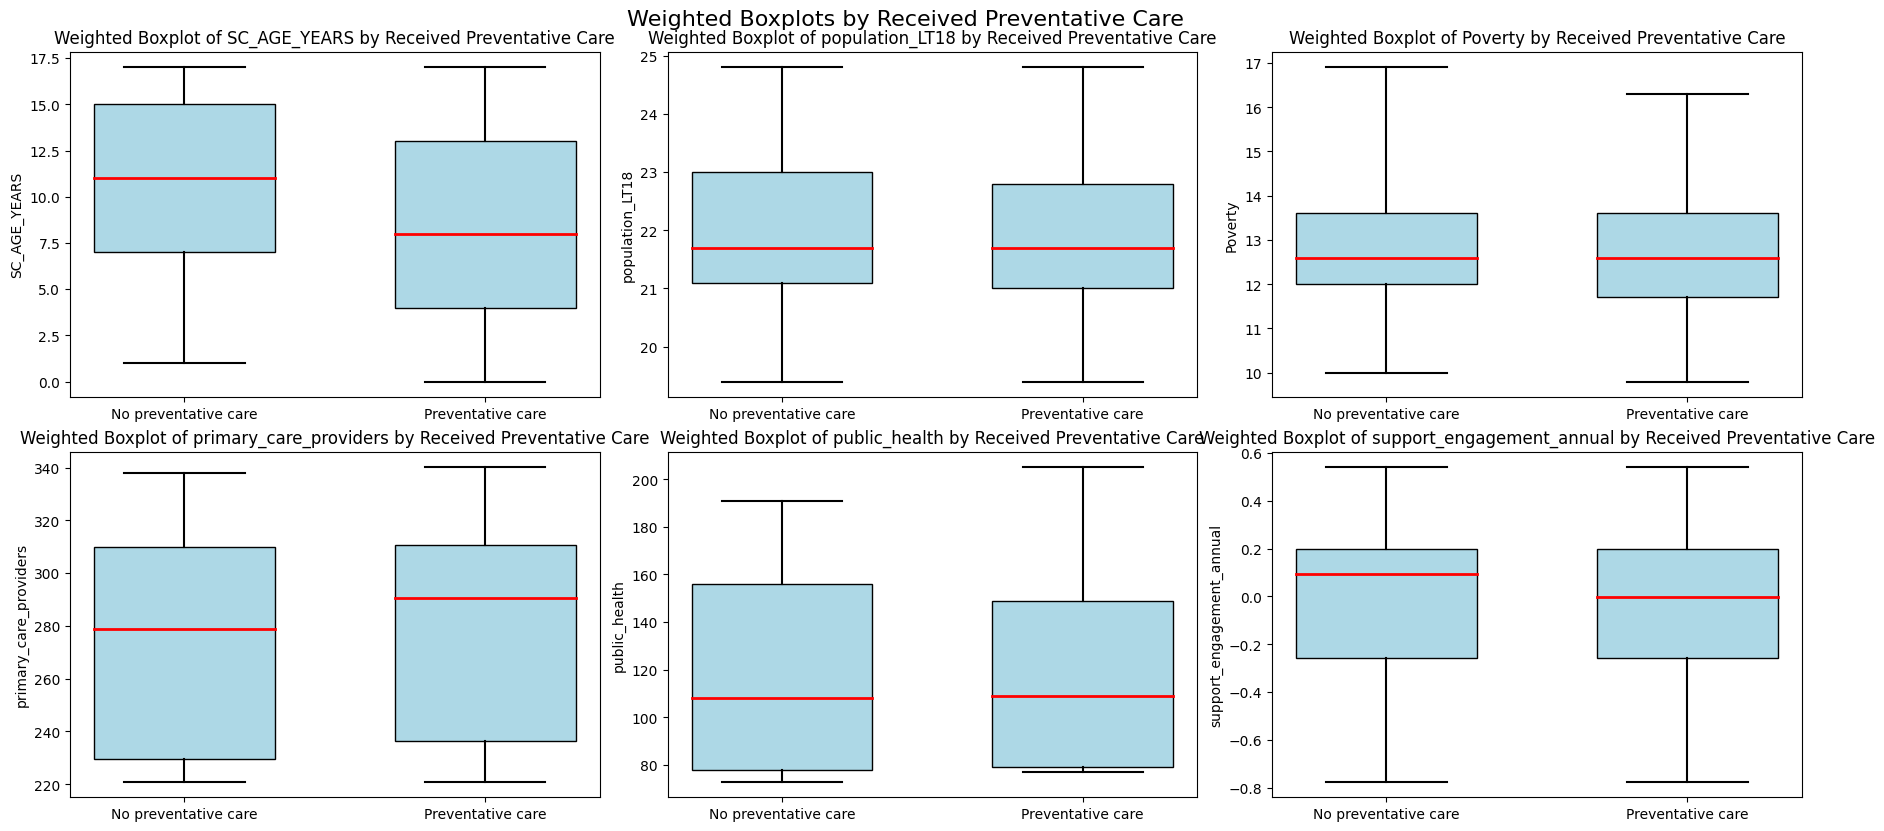

In [18]:
vars_to_plot = ["SC_AGE_YEARS", "population_LT18", "Poverty", 
                "primary_care_providers", "public_health", 
                "support_engagement_annual"
]

cats = df_fam_xgb["PrevMed_23_labeled"].unique()
cats = list(sorted(cats))  # ensure consistent ordering

n_vars = len(vars_to_plot)
cols = 3
rows = math.ceil(n_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), constrained_layout=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    box_data = []
    for c in cats:
        subset = df_fam_xgb[df_fam_xgb["PrevMed_23_labeled"] == c]
        q1, med, q3 = weighted_quantile(
            subset[var],
            quantiles=[0.25, 0.50, 0.75],
            sample_weight=subset["FWC"]
        )
        # whiskers
        low, high = weighted_quantile(
            subset[var],
            quantiles=[0.05, 0.95],   # optional whisker definition
            sample_weight=subset["FWC"]
        )

        box_data.append({
            "label": c,
            "q1": q1,
            "med": med,
            "q3": q3,
            "low": low,
            "high": high
        })

    # Draw custom weighted boxplot
    for j, bd in enumerate(box_data):
        x = j + 1

        # Box
        ax.add_patch(plt.Rectangle((x - 0.3, bd["q1"]),
                                   0.6,
                                   bd["q3"] - bd["q1"],
                                   fill=True,
                                   edgecolor='black',
                                   facecolor='lightblue'))

        # Median
        ax.plot([x - 0.3, x + 0.3], [bd["med"], bd["med"]], color='red', linewidth=2)

        # Whiskers
        ax.plot([x, x], [bd["low"], bd["q1"]], color='black')
        ax.plot([x, x], [bd["q3"], bd["high"]], color='black')

        # Whisker caps
        ax.plot([x - 0.2, x + 0.2], [bd["low"], bd["low"]], color='black')
        ax.plot([x - 0.2, x + 0.2], [bd["high"], bd["high"]], color='black')

    ax.set_xticks(range(1, len(cats) + 1))
    ax.set_xticklabels(cats)
    ax.set_title(f"Weighted Boxplot of {var} by Received Preventative Care")
    ax.set_ylabel(var)

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Weighted Boxplots by Received Preventative Care", fontsize=16, y=1.02)
plt.show()

### Convert categorical variables as needed

- K2Q01: Health Status: 1=Excellent, 2=Very Good, 3=Good, 4=Fair, 5=Poor 
- SC_SEX: Child's sex: 1=Male, 2=Female
- TOTKIDS_R: Total kids in the household: 1=1, 2=2, 3=3, 4=4 or more 
- HousingInstab_23: Housing instability: 1=Yes, 2=No
- WIC_23: WIC: 1=Yes, 2=No
- FoodCash_23: Someone in family received food or cash in last 12 months: 1=received food/case from 3-5 sources, 2=received food/case from 1-2 sources, 3=did not receive
- povlev4_23: Poverty level: 1=< 99, 2=100-199, 3=200-399, 4=400 or more
- FamCount_23: Count of family members living in the house: 1=1 or 2 people, 2=3 people, 3=4 people, 4=5 people, 5=6 or more 
- K4Q01: Place for care: 1=Yes, 2=No
- smAdeqIns_23: Adequate and continuous insurance: 1=Yes, 2=No
- ScreenTime_23: Screen time per day: 1 = Less than 1 hour, 2 = 1 hour, 3 = 2 hours, 4 = 3 hours, 5 = 4 or more hours
- HrsSleep_23: Adequate sleep for age: 1=adequate for age, 2=inadequate for age
- Region: Midwest, West, South, Northeast

In [19]:
df_fam_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54159 entries, 0 to 54158
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   STATE                      54159 non-null  object  
 1   FWC                        54159 non-null  float64 
 2   K2Q01                      54159 non-null  int64   
 3   SC_AGE_YEARS               54159 non-null  int64   
 4   SC_SEX                     54159 non-null  int64   
 5   TOTKIDS_R                  54159 non-null  int64   
 6   HousingInstab_23           54159 non-null  int64   
 7   WIC_23                     54159 non-null  int64   
 8   FoodCash_23                54159 non-null  int64   
 9   povlev4_23                 54159 non-null  int64   
 10  FamCount_23                54159 non-null  int64   
 11  K4Q01                      54159 non-null  int64   
 12  smAdeqIns_23               54159 non-null  int64   
 13  ScreenTime_23              5415

In [20]:
# Binary mapping: Yes/No to 1/0
binary_vars = ['HousingInstab_23', 'WIC_23', 'K4Q01', 'smAdeqIns_23', 'HrsSleep_23', 'SC_SEX']
binary_mapping = {
    1: 1,  # Yes or Male
    2: 0   # No or Female
}

for var in binary_vars:
    df_fam_xgb[var] = df_fam_xgb[var].map(binary_mapping)

# Ordinal variables (keep integers, but optionally set as categorical for clarity)
ordinal_vars = ['K2Q01', 'TOTKIDS_R', 'FoodCash_23', 'povlev4_23', 'FamCount_23', 'ScreenTime_23', "AdultEduc_23"]

# Optionally make them categorical with ordered=True for clarity
for var in ordinal_vars:
    df_fam_xgb[var] = pd.Categorical(df_fam_xgb[var], ordered=True)

# Optional: verify
df_fam_xgb[binary_vars + ordinal_vars].head()

,HousingInstab_23,WIC_23,K4Q01,smAdeqIns_23,HrsSleep_23,SC_SEX,K2Q01,TOTKIDS_R,FoodCash_23,povlev4_23,FamCount_23,ScreenTime_23,AdultEduc_23
0,0,0,0,1,0,1,2,1,2,3,2,4,3
1,0,0,1,1,1,0,2,2,2,4,3,5,4
2,0,0,1,1,1,0,3,1,2,2,4,4,2
3,0,0,1,1,1,0,1,2,2,2,3,4,3
4,0,0,0,0,1,0,1,2,3,2,3,5,2


In [21]:
# One-hot encode Region
df_fam_xgb = pd.get_dummies(df_fam_xgb, columns=['Region'], drop_first=True)

In [22]:
df_fam_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54159 entries, 0 to 54158
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   STATE                      54159 non-null  object  
 1   FWC                        54159 non-null  float64 
 2   K2Q01                      54159 non-null  category
 3   SC_AGE_YEARS               54159 non-null  int64   
 4   SC_SEX                     54159 non-null  int64   
 5   TOTKIDS_R                  54159 non-null  category
 6   HousingInstab_23           54159 non-null  int64   
 7   WIC_23                     54159 non-null  int64   
 8   FoodCash_23                54159 non-null  category
 9   povlev4_23                 54159 non-null  category
 10  FamCount_23                54159 non-null  category
 11  K4Q01                      54159 non-null  int64   
 12  smAdeqIns_23               54159 non-null  int64   
 13  ScreenTime_23              5415

In [23]:
df_fam_xgb['noprecare'].value_counts()

noprecare
0    45287
1     8872
Name: count, dtype: Int64

In [24]:
# Displaying the data before splitting
features = ["K2Q01", "SC_AGE_YEARS", "SC_SEX", "HousingInstab_23", 
            "WIC_23", "FoodCash_23", "povlev4_23", "FamCount_23",
            "K4Q01", "smAdeqIns_23", "ScreenTime_23", "HrsSleep_23",  
            "AdultEduc_23",
            "population_LT18", "primary_care_providers", 
            "public_health", "support_engagement_annual",
            "Region_Northeast", "Region_South", "Region_West"]

target = 'noprecare'

FWC = df_fam_xgb['FWC']

display(df_fam_xgb[features].head())
display(df_fam_xgb[target].head())

,K2Q01,SC_AGE_YEARS,SC_SEX,HousingInstab_23,WIC_23,FoodCash_23,povlev4_23,FamCount_23,K4Q01,smAdeqIns_23,ScreenTime_23,HrsSleep_23,AdultEduc_23,population_LT18,primary_care_providers,public_health,support_engagement_annual,Region_Northeast,Region_South,Region_West
0,2,11,1,0,0,2,3,2,0,1,4,0,3,21.7,229.7,173.0,0.199,False,False,True
1,2,14,0,0,0,2,4,3,1,1,5,1,4,21.7,229.7,173.0,0.199,False,False,True
2,3,17,0,0,0,2,2,4,1,1,4,1,2,21.7,229.7,173.0,0.199,False,False,True
3,1,12,0,0,0,2,2,3,1,1,4,1,3,21.7,229.7,173.0,0.199,False,False,True
4,1,10,0,0,0,3,2,3,0,0,5,1,2,21.7,229.7,173.0,0.199,False,False,True


0    0
1    0
2    0
3    1
4    1
Name: noprecare, dtype: Int64

In [25]:
# Splitting the dataset into the Training set and Test set
# Add stratify=y to maintain class-balanced split, maintain label proportions and improve reliability

X_train, X_test, y_train, y_test, FWC_train, FWC_test = train_test_split(df_fam_xgb[features],df_fam_xgb[target],FWC, 
                                                                         test_size=0.2,random_state=4567, stratify=df_fam_xgb[target])

In [26]:
def weighted_class_summary(y, weights):
    """
    Computes weighted counts and weighted percentages for each class.
    """
    df = pd.DataFrame({'y': y, 'w': weights})

    # Weighted counts per class
    weighted_counts = df.groupby('y')['w'].sum()

    # Weighted percentages
    weighted_percentages = (weighted_counts / weighted_counts.sum()) * 100

    summary = pd.DataFrame({
        'Weighted Count': weighted_counts.round(2),
        'Weighted Percentage': weighted_percentages.round(2)
    })

    return summary

# ---- Training set ----
print("Training Set Weighted Class Distribution:")
train_summary = weighted_class_summary(y_train, FWC_train)
display(train_summary)

# ---- Test set ----
print("Test Set Weighted Class Distribution:")
test_summary = weighted_class_summary(y_test, FWC_test)
display(test_summary)

Training Set Weighted Class Distribution:


,Weighted Count,Weighted Percentage
y,,
0,44782881.31,79.45
1,11583223.48,20.55


Test Set Weighted Class Distribution:


,Weighted Count,Weighted Percentage
y,,
0,11220310.05,79.17
1,2951961.59,20.83


In [27]:
# display the data after splitting

# Training set
display(pd.DataFrame(X_train).head())
display(pd.DataFrame(y_train).head())

# Test set
display(pd.DataFrame(X_test).head())
display(pd.DataFrame(y_test).head())
 

,K2Q01,SC_AGE_YEARS,SC_SEX,HousingInstab_23,WIC_23,FoodCash_23,povlev4_23,FamCount_23,K4Q01,smAdeqIns_23,ScreenTime_23,HrsSleep_23,AdultEduc_23,population_LT18,primary_care_providers,public_health,support_engagement_annual,Region_Northeast,Region_South,Region_West
33138,1,12,0,0,0,2,4,3,1,1,5,1,4,20.3,317.6,79.0,-0.004,True,False,False
32424,2,7,1,0,0,2,1,4,1,1,2,0,3,21.9,307.5,97.0,-0.258,False,False,False
22973,1,7,1,0,0,1,3,4,1,1,2,1,4,23.6,300.9,95.0,-0.145,False,False,False
53406,3,17,1,0,0,1,3,3,0,0,5,0,4,21.3,266.0,102.0,-0.114,False,True,False
18933,1,14,0,0,0,1,4,3,1,1,5,1,4,21.1,307.4,69.0,-0.195,False,False,False


,noprecare
33138,0
32424,0
22973,0
53406,0
18933,0


,K2Q01,SC_AGE_YEARS,SC_SEX,HousingInstab_23,WIC_23,FoodCash_23,povlev4_23,FamCount_23,K4Q01,smAdeqIns_23,ScreenTime_23,HrsSleep_23,AdultEduc_23,population_LT18,primary_care_providers,public_health,support_engagement_annual,Region_Northeast,Region_South,Region_West
31917,1,5,1,0,0,1,4,3,1,1,3,1,4,23.1,278.7,73.0,-0.633,False,False,False
43786,2,14,1,0,0,1,4,2,1,1,5,1,4,21.7,229.7,173.0,0.199,False,False,True
40897,2,13,1,0,0,1,4,3,1,1,5,1,4,20.3,317.6,79.0,-0.004,True,False,False
35439,3,10,1,1,1,3,1,2,1,1,4,1,3,21.1,307.4,69.0,-0.195,False,False,False
44110,1,13,0,0,0,3,1,1,0,1,4,1,2,21.7,229.7,173.0,0.199,False,False,True


,noprecare
31917,1
43786,0
40897,0
35439,0
44110,0


In [28]:
weighted_pos = FWC_train[y_train == 1].sum()
weighted_neg = FWC_train[y_train == 0].sum()

spw = weighted_neg / weighted_pos
print("scale_pos_weight:", spw)

#Using the weighted counts get 3.87 (if used the unweighted counts would get 5.1)

scale_pos_weight: 3.866184691453038


In [29]:
# Implementing XGBoost classifier

classifier = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    max_depth=4,             
    learning_rate=0.05,      
    n_estimators=300, 
    enable_categorical=True,
    scale_pos_weight=spw,
    random_state=4567
)

classifier.fit(
    X_train,
    y_train,
    sample_weight=FWC_train,
    eval_set=[(X_test, y_test)], 
    sample_weight_eval_set=[FWC_test],
    verbose=True  
)

[0]	validation_0-logloss:0.68643
[1]	validation_0-logloss:0.68051
[2]	validation_0-logloss:0.67512
[3]	validation_0-logloss:0.67006
[4]	validation_0-logloss:0.66559
[5]	validation_0-logloss:0.66147
[6]	validation_0-logloss:0.65765
[7]	validation_0-logloss:0.65417
[8]	validation_0-logloss:0.65096
[9]	validation_0-logloss:0.64802
[10]	validation_0-logloss:0.64538
[11]	validation_0-logloss:0.64294
[12]	validation_0-logloss:0.64075
[13]	validation_0-logloss:0.63878
[14]	validation_0-logloss:0.63689
[15]	validation_0-logloss:0.63532
[16]	validation_0-logloss:0.63377
[17]	validation_0-logloss:0.63220
[18]	validation_0-logloss:0.63098
[19]	validation_0-logloss:0.62973
[20]	validation_0-logloss:0.62859
[21]	validation_0-logloss:0.62753
[22]	validation_0-logloss:0.62611
[23]	validation_0-logloss:0.62509
[24]	validation_0-logloss:0.62404
[25]	validation_0-logloss:0.62333
[26]	validation_0-logloss:0.62273
[27]	validation_0-logloss:0.62163
[28]	validation_0-logloss:0.62102
[29]	validation_0-loglos

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'logloss'


In [30]:
# Look at the best model hyperparameters
print (classifier.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': True, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 4567, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': np.float64(3.866184691453038), 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [31]:
# Check that the model generalizes well (bc used X_test in the eval set):
y_pred_proba = classifier.predict_proba(X_test)[:, 1]

log_loss(y_test, y_pred_proba, sample_weight=FWC_test)


0.5997886144789347

In [32]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Base classifier
classifier = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    enable_categorical=True,
    random_state=4567
)

# Parameter grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300, 500],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'min_child_weight': [1, 3],
    'scale_pos_weight': [spw, spw*1.5, spw*2]  # weighting the minority class
}

# Use weighted F1 as scoring to handle class imbalance
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, pos_label=1, greater_is_better=True)

# Grid search with 3-fold CV
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit with sample weights
grid_search.fit(
    X_train,
    y_train,
    sample_weight=FWC_train
)

# Best hyperparameters
print("Best parameters found:", grid_search.best_params_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': np.float64(3.866184691453038), 'subsample': 0.7}


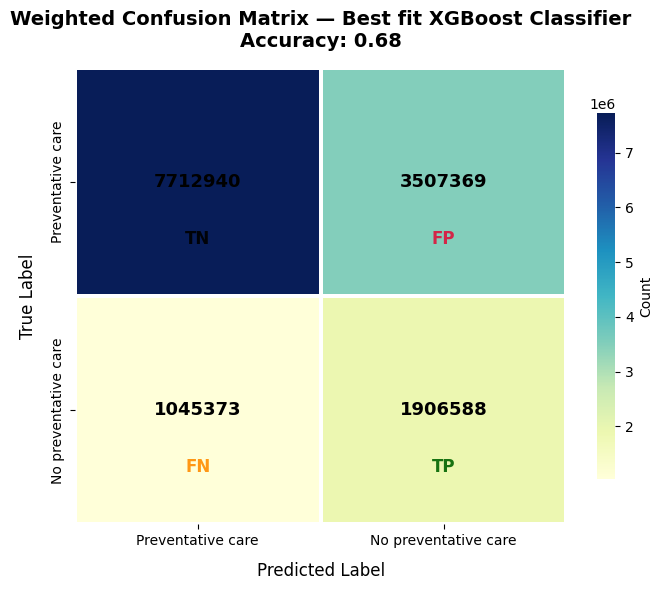

In [33]:
# Generating the confusion matrix

# Predictions
preds_bxgb = best_model.predict(X_test)

# Compute weighted confusion matrix and weighted accuracy
conf_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': preds_bxgb,
    'weight': FWC_test
})

# Group by true and predicted labels and sum weights
weighted_cm = conf_df.groupby(['y_true', 'y_pred'])['weight'].sum().unstack(fill_value=0)

# Ensure matrix shape is 2x2
weighted_cm = weighted_cm.reindex(index=[0,1], columns=[0,1], fill_value=0).values.astype(int)

acc = accuracy_score(y_test, preds_bxgb, sample_weight=FWC_test)

# Class labels
labels = ["Preventative care", "No preventative care"]

# Plot setup
plt.figure(figsize=(7,6))
ax = sns.heatmap(weighted_cm, annot=True, fmt='d',
                 cmap='YlGnBu',
                 linewidths=1.5, linecolor='white',
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'shrink':0.8, 'label':'Count'},
                 annot_kws={'size':13, 'weight':'bold', 'color':'black'})

plt.title(f"Weighted Confusion Matrix — Best fit XGBoost Classifier\nAccuracy: {acc:.2f}",
          fontsize=14, weight='bold', pad=15)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)

# Label coordinates (slightly below numeric counts)
offset_y = 0.25  # small downward shift from center

# Overlay TN / FP / FN / TP *below* the numbers
for i in range(weighted_cm.shape[0]):
    for j in range(weighted_cm.shape[1]):
        if i == 0 and j == 0:
            label, color = "TN", "black"
        elif i == 0 and j == 1:
            label, color = "FP", "crimson"
        elif i == 1 and j == 0:
            label, color = "FN", "darkorange"
        else:
            label, color = "TP", "darkgreen"

        ax.text(j + 0.5, i + 0.5 + offset_y, label,
                color=color, fontsize=12, weight='bold',
                ha='center', va='center', alpha=0.9)

plt.tight_layout()
plt.show()

In [34]:
# Accuracy, F1 Score and Recall Score

# See final program for text on what these are

accuracy = accuracy_score(y_test, preds_bxgb, sample_weight=FWC_test)
f1 = f1_score(y_test, preds_bxgb, sample_weight=FWC_test)
recall = recall_score(y_test, preds_bxgb, sample_weight=FWC_test)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.68
F1 Score: 0.46
Recall: 0.65


In [36]:
print(weighted_cm)

[[7712940 3507369]
 [1045373 1906588]]
